In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import pandas as pd
import torch
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from lib.metrics import c_index, dynamic_c_index
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

In [2]:
random_state = 42
torch.manual_seed(random_state)
device = "cuda" if torch.cuda.is_available() else "cpu"

# Load data


In [3]:
path = "dataset/Breast Cancer METABRIC.csv"
df = pd.read_csv(path)
df.head()

,Patient ID,Age at Diagnosis,Type of Breast Surgery,Cancer Type,Cancer Type Detailed,Cellularity,Chemotherapy,Pam50 + Claudin-low subtype,Cohort,ER status measured by IHC,...,Overall Survival Status,PR Status,Radio Therapy,Relapse Free Status (Months),Relapse Free Status,Sex,3-Gene classifier subtype,Tumor Size,Tumor Stage,Patient's Vital Status
0,MB-0000,75.65,Mastectomy,Breast Cancer,Breast Invasive Ductal Carcinoma,NaN,No,claudin-low,1.0,Positve,...,Living,Negative,Yes,138.65,Not Recurred,Female,ER-/HER2-,22.0,2.0,Living
1,MB-0002,43.19,Breast Conserving,Breast Cancer,Breast Invasive Ductal Carcinoma,High,No,LumA,1.0,Positve,...,Living,Positive,Yes,83.52,Not Recurred,Female,ER+/HER2- High Prolif,10.0,1.0,Living
2,MB-0005,48.87,Mastectomy,Breast Cancer,Breast Invasive Ductal Carcinoma,High,Yes,LumB,1.0,Positve,...,Deceased,Positive,No,151.28,Recurred,Female,NaN,15.0,2.0,Died of Disease
3,MB-0006,47.68,Mastectomy,Breast Cancer,Breast Mixed Ductal and Lobular Carcinoma,Moderate,Yes,LumB,1.0,Positve,...,Living,Positive,Yes,162.76,Not Recurred,Female,NaN,25.0,2.0,Living
4,MB-0008,76.97,Mastectomy,Breast Cancer,Breast Mixed Ductal and Lobular Carcinoma,High,Yes,LumB,1.0,Positve,...,Deceased,Positive,Yes,18.55,Recurred,Female,ER+/HER2- High Prolif,40.0,2.0,Died of Disease


In [4]:
patient_meta_cols = ["Patient ID", "Oncotree Code", "Cohort"]
demographic_cols = ["Age at Diagnosis", "Sex", "Inferred Menopausal State"]
cancer_characteristics_cols = [
    "Cancer Type",
    "Cancer Type Detailed",
    "Cellularity",
    "Neoplasm Histologic Grade",
    "Tumor Other Histologic Subtype",
    "Tumor Size",
    "Tumor Stage",
    "Primary Tumor Laterality",
]
biomarker_cols = [
    "ER Status",
    "ER status measured by IHC",
    "PR Status",
    "HER2 Status",
    "HER2 status measured by SNP6",
    "Pam50 + Claudin-low subtype",
    "3-Gene classifier subtype",
    "Integrative Cluster",
]
treatment_cols = [
    "Type of Breast Surgery",
    "Hormone Therapy",
    "Chemotherapy",
    "Radio Therapy",
]
clinical_outcome_cols = [
    "Overall Survival (Months)",
    "Overall Survival Status",
    "Patient's Vital Status",
    "Relapse Free Status (Months)",
    "Relapse Free Status",
]
clinical_metrics_cols = [
    "Lymph nodes examined positive",
    "Mutation Count",
    "Nottingham prognostic index",
]

In [5]:
df["Type of Breast Surgery"] = (
    df.groupby(["Cancer Type Detailed"])["Type of Breast Surgery"]
    .apply(lambda x: x.fillna(x.mode()[0]))
    .sort_index(level=1)
    .values
)
# Fill event and duration null values with the mean or the most frequent value
grouped_df = df.groupby(["Cancer Type Detailed"])["Relapse Free Status"].apply(
    lambda x: x.fillna(x.mode()[0])
)
df["Relapse Free Status"] = grouped_df.sort_index(level=1).values
grouped_df = df.groupby(["Cancer Type Detailed"])["Relapse Free Status (Months)"].apply(
    lambda x: x.fillna(x.mean())
)
df["Relapse Free Status (Months)"] = grouped_df.sort_index(level=1).values
# Since the relapse free status has two classes, we have to have two level of grouping
grouped_df = df.groupby(["Cancer Type Detailed", "Relapse Free Status"])[
    "Overall Survival Status"
].apply(lambda x: x.fillna(x.mode()[0]))
df["Overall Survival Status"] = grouped_df.sort_index(level=2).values
grouped_df = df.groupby(["Cancer Type Detailed", "Overall Survival Status"])[
    "Overall Survival (Months)"
].apply(lambda x: x.fillna(x.mean()))
df["Overall Survival (Months)"] = grouped_df.sort_index(level=2).values
# Fill null values in treatment columns with mode of each cancer type detailed
# For each cancer type detailed, find the mode of each treatment column and fill null values with that mode
grouped_df = df.groupby(["Cancer Type Detailed"])["Chemotherapy"].apply(
    lambda x: x.fillna(x.mode()[0])
)
df["Chemotherapy"] = grouped_df.sort_index(level=1).values
grouped_df = df.groupby(["Cancer Type Detailed"])["Hormone Therapy"].apply(
    lambda x: x.fillna(x.mode()[0])
)
df["Hormone Therapy"] = grouped_df.sort_index(level=1).values
grouped_df = df.groupby(["Cancer Type Detailed"])["Radio Therapy"].apply(
    lambda x: x.fillna(x.mode()[0])
)
df["Radio Therapy"] = grouped_df.sort_index(level=1).values
df["ER status measured by IHC"] = df["ER status measured by IHC"].fillna(
    df["ER status measured by IHC"].mode()[0]
)
grouped_df = df.groupby(["ER status measured by IHC"])["ER Status"].apply(
    lambda x: x.fillna(x.mode()[0])
)
df["ER Status"] = grouped_df.sort_index(level=1).values
df["HER2 status measured by SNP6"] = df["HER2 status measured by SNP6"].fillna(
    df["HER2 status measured by SNP6"].mode()[0]
)
grouped_df = df.groupby(["HER2 status measured by SNP6"])["HER2 Status"].apply(
    lambda x: x.fillna(x.mode()[0])
)
df["HER2 Status"] = grouped_df.sort_index(level=1).values
grouped_df = df.groupby(["Cancer Type Detailed"])["PR Status"].apply(
    lambda x: x.fillna(x.mode()[0])
)
df["PR Status"] = grouped_df.sort_index(level=1).values
df["Pam50 + Claudin-low subtype"] = df["Pam50 + Claudin-low subtype"].fillna(
    df["Pam50 + Claudin-low subtype"].mode()[0]
)
df["3-Gene classifier subtype"] = (
    df.groupby(["Cancer Type Detailed"])["3-Gene classifier subtype"]
    .apply(lambda x: x.fillna(x.mode()[0]))
    .sort_index(level=1)
    .values
)
df["Integrative Cluster"] = (
    df.groupby(["Cancer Type Detailed"])["Integrative Cluster"]
    .apply(lambda x: x.fillna(x.mode()[0]))
    .sort_index(level=1)
    .values
)
df["Cohort"] = (
    df.groupby(["Cancer Type Detailed"])["Cohort"]
    .apply(lambda x: x.fillna(x.mode()[0]))
    .sort_index(level=1)
    .values
)
# Fill null age at diagnosis with the mean age of each cancer type detailed
df["Age at Diagnosis"] = (
    df.groupby(["Cancer Type Detailed"])["Age at Diagnosis"]
    .apply(lambda x: x.fillna(x.mean()))
    .sort_index(level=1)
    .values
)

# Fill the inferred menopausal state with the common state
df["Inferred Menopausal State"] = df["Inferred Menopausal State"].fillna(
    df["Inferred Menopausal State"].mode()[0]
)
df["Cellularity"] = (
    df.groupby(["Cancer Type Detailed"])["Cellularity"]
    .apply(lambda x: x.fillna(x.mode()[0]))
    .sort_index(level=1)
    .values
)
# Need to have fall back mechanism as their exists cases where all cellularity values are null for a given cancer type detailed
df["Tumor Stage"] = (
    df.groupby(["Cancer Type Detailed", "Cellularity"])["Tumor Stage"]
    .apply(lambda x: x.fillna(x.median()))
    .sort_index(level=2)
    .values
)
df["Tumor Stage"] = (
    df.groupby(["Cancer Type Detailed"])["Tumor Stage"]
    .apply(lambda x: x.fillna(x.median()))
    .sort_index(level=1)
    .values
)
# 3 fallback levels to fill tumor size as there exists cases where all tumor size values are null for a given cancer type detailed and tumor stage
df["Tumor Size"] = (
    df.groupby(["Cancer Type Detailed", "Tumor Stage"])["Tumor Size"]
    .apply(lambda x: x.fillna(x.median()))
    .sort_index(level=2)
    .values
)
df["Tumor Size"] = (
    df.groupby(["Cancer Type Detailed"])["Tumor Size"]
    .apply(lambda x: x.fillna(x.median()))
    .sort_index(level=1)
    .values
)
df["Tumor Size"] = df["Tumor Size"].fillna(df["Tumor Size"].median())
# 2 fallback levels to fill neoplasm histologic grade as there exists cases where all neoplasm histologic grade values are null for a given cancer type detailed
df["Neoplasm Histologic Grade"] = (
    df.groupby(["Cancer Type Detailed"])["Neoplasm Histologic Grade"]
    .apply(lambda x: x.fillna(x.mode()))
    .sort_index(level=1)
    .values
)
df["Neoplasm Histologic Grade"] = df["Neoplasm Histologic Grade"].fillna(
    df["Neoplasm Histologic Grade"].mode()[0]
)
df["Tumor Other Histologic Subtype"] = (
    df.groupby(["Cancer Type Detailed"])["Tumor Other Histologic Subtype"]
    .apply(lambda x: x.fillna(x.mode()))
    .sort_index(level=1)
    .values
)
df["Tumor Other Histologic Subtype"] = df["Tumor Other Histologic Subtype"].fillna(
    "Ductal/NST"
)
df["Primary Tumor Laterality"] = (
    df.groupby(["Cancer Type Detailed"])["Primary Tumor Laterality"]
    .apply(lambda x: x.fillna(x.mode()[0]))
    .sort_index(level=1)
    .values
)
df["Lymph nodes examined positive"] = (
    df.groupby(["Cancer Type Detailed"])["Lymph nodes examined positive"]
    .apply(lambda x: x.fillna(x.mode()))
    .sort_index(level=1)
    .values
)
df["Lymph nodes examined positive"] = df["Lymph nodes examined positive"].fillna(
    df["Lymph nodes examined positive"].mode()[0]
)
df["Mutation Count"] = (
    df.groupby(["Cancer Type Detailed"])["Mutation Count"]
    .apply(lambda x: x.fillna(x.mode()))
    .sort_index(level=1)
    .values
)
df["Mutation Count"] = df["Mutation Count"].fillna(df["Mutation Count"].mode()[0])
df["Nottingham prognostic index"] = (
    df.groupby(["Tumor Size"])["Nottingham prognostic index"]
    .apply(lambda x: x.fillna(x.median()))
    .sort_index(level=1)
    .values
)
df["Nottingham prognostic index"] = df["Nottingham prognostic index"].fillna(
    df["Nottingham prognostic index"].median()
)
# drop patient vital status as it is redundant with overall survival status
df.drop(columns=["Patient's Vital Status", "Patient ID"], inplace=True)

/Users/riezmann/miniconda3/envs/survival_analysis/lib/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:1214: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/Users/riezmann/miniconda3/envs/survival_analysis/lib/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:1214: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/Users/riezmann/miniconda3/envs/survival_analysis/lib/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:1214: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/Users/riezmann/miniconda3/envs/survival_analysis/lib/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:1214: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/Users/riezmann/miniconda3/envs/survival_analysis/lib/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:1214: RuntimeWarning: Mean of empty slice
  retur

In [6]:
numeric_cols = df._get_numeric_data().columns
categorical_cols = df.select_dtypes(include=["object", "bool"]).columns
object_cols = [
    "Type of Breast Surgery",
    "Cancer Type",
    "Cancer Type Detailed",
    "Cellularity",
    "Chemotherapy",
    "Chemotherapy",
    "Pam50 + Claudin-low subtype",
    "ER status measured by IHC",
    "ER Status",
    "HER2 status measured by SNP6",
    "HER2 Status",
    "Tumor Other Histologic Subtype",
    "Hormone Therapy",
    "Inferred Menopausal State",
    "Integrative Cluster",
    "Primary Tumor Laterality",
    "Oncotree Code",
    "PR Status",
    "Radio Therapy",
    "Sex",
    "3-Gene classifier subtype",
]

for col in object_cols:
    df[col] = np.uint8(LabelEncoder().fit_transform(df[col]))

df["Overall Survival Status"] = np.uint8(
    df["Overall Survival Status"].map({"Living": 0, "Deceased": 1})
)
df["Relapse Free Status"] = np.uint8(
    df["Relapse Free Status"].map({"Not Recurred": 0, "Recurred": 1})
)

In [7]:
features = (
    demographic_cols
    + cancer_characteristics_cols
    + biomarker_cols
    + treatment_cols
    + clinical_metrics_cols
)
overall_survival_cols = ["Overall Survival (Months)", "Overall Survival Status"]
relapse_free_cols = ["Relapse Free Status (Months)", "Relapse Free Status"]

In [8]:
# Assuming 'df' is your Pandas DataFrame
# 'features' are your independent variables, 'target' is your dependent variable
X = df[features]
y = df[overall_survival_cols]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=random_state
)

In [9]:
X_train

,Age at Diagnosis,Sex,Inferred Menopausal State,Cancer Type,Cancer Type Detailed,Cellularity,Neoplasm Histologic Grade,Tumor Other Histologic Subtype,Tumor Size,Tumor Stage,...,Pam50 + Claudin-low subtype,3-Gene classifier subtype,Integrative Cluster,Type of Breast Surgery,Hormone Therapy,Chemotherapy,Radio Therapy,Lymph nodes examined positive,Mutation Count,Nottingham prognostic index
263,72.69,0,0,0,2,0,3.0,0,23.0,2.0,...,5,2,1,1,0,0,1,1.0,3.0,5.046
1512,35.13,0,1,0,2,1,3.0,0,75.0,3.0,...,0,3,6,1,0,1,0,1.0,9.0,5.150
2167,86.21,0,0,0,2,0,3.0,0,27.0,2.0,...,2,0,9,1,1,0,1,11.0,7.0,6.600
1213,72.02,0,0,0,3,0,3.0,1,18.0,2.0,...,3,0,9,1,1,0,0,0.0,7.0,4.036
415,61.53,0,0,0,2,0,3.0,0,29.0,2.0,...,1,3,6,1,1,1,1,8.0,4.0,6.058
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1638,76.99,0,0,0,2,0,3.0,0,15.0,2.0,...,2,0,3,1,1,0,0,15.0,7.0,6.030
1095,64.30,0,0,0,2,2,3.0,0,45.0,3.0,...,6,3,6,1,0,1,1,1.0,6.0,5.000
1130,72.54,0,0,0,2,2,3.0,0,22.0,2.0,...,2,1,9,0,1,0,1,5.0,6.0,6.044
1294,61.28,0,0,0,2,2,3.0,0,25.0,2.0,...,1,3,6,1,1,0,0,0.0,5.0,3.050


# Metabric dataset


In [10]:
class MetabricDataset(Dataset):
    def __init__(self, X, y):
        self.features = X
        self.labels = y

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        data = self.features[idx]
        label = self.labels[idx]
        return data, label

# Define model


In [11]:
class BaseSurvivalClass(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = features
        self.categorical_cols = [
            col for col in categorical_cols if col in self.features
        ]
        self.numerical_cols = [col for col in numeric_cols if col in self.features]
        self.embeddings = nn.ModuleDict()
        for col in self.categorical_cols:
            num_unique_values = int(df[col].nunique())
            embedding_size = 8
            self.embeddings[col] = nn.Embedding(num_unique_values, embedding_size)

    def embed_with_time(self, x, t):
        embedded_cols = []
        for col in self.categorical_cols:
            # ndarray = np.array()
            embedded_col = self.embeddings[col](x[:, self.features.index(col)].long())
            # print(embedded_col.shape)
            embedded_cols.append(embedded_col)
        numerical_data = torch.stack(
            [
                torch.tensor(x[:, self.features.index(col)])
                for col in self.numerical_cols
                if col != "Overall Survival (Months)"
            ],
            dim=1,
        ).float()
        time_data = torch.reshape(t, (x.shape[0], 1)).float()

        x = torch.cat(embedded_cols + [numerical_data, time_data], dim=1)
        return time_data

    def embed_without_time(self, x):
        embedded_cols = []
        for col in self.categorical_cols:
            embedded_col = self.embeddings[col](x[:, self.features.index(col)].long())
            embedded_cols.append(embedded_col)
        numerical_data = torch.stack(
            [
                torch.tensor(x[:, self.features.index(col)])
                for col in self.numerical_cols
                if col != "Overall Survival (Months)"
            ],
            dim=1,
        ).float()
        x = torch.cat(embedded_cols + [numerical_data], dim=1)
        return x

    def forward(self, x):
        raise NotImplementedError("Forward method not implemented!")

In [142]:
class FullyParameterizedSurvivalModel(BaseSurvivalClass):
    def __init__(self):
        super().__init__()
        self.net_without_time = nn.Sequential(
            nn.LazyLinear(64),
            nn.ReLU(),
            nn.LazyLinear(128),
            nn.ReLU(),
            nn.LazyLinear(128),
            nn.ReLU(),
            nn.LazyLinear(64),
            nn.ReLU(),
            nn.LazyLinear(32),
            nn.ReLU(),
            nn.LazyLinear(1),
            nn.Sigmoid(),
        )

        self.net_with_time = nn.Sequential(
            nn.LazyLinear(64),
            nn.ReLU(),
            nn.LazyLinear(32),
            nn.ReLU(),
            nn.LazyLinear(32),
            nn.ReLU(),
            nn.LazyLinear(1),
            nn.Sigmoid(),
        )

    def forward(self, x, t):
        x_without_time = self.embed_without_time(x)
        x_with_time = self.embed_with_time(x, t)
        per_patient_hazard = self.net_without_time(x_without_time)
        baseline_hazard = self.net_with_time(x_with_time)
        return baseline_hazard * per_patient_hazard


class CoxPHLoss(nn.Module):
    """
    Cox Proportional Hazards partial likelihood loss.
    Efficient implementation using the Breslow approximation for tied events.
    """

    def __init__(self):
        super().__init__()

    def forward(
        self, model: FullyParameterizedSurvivalModel, features, durations, events
    ):
        """
        Args:
            log_h: log hazard ratio predictions from model, shape (batch_size,)
            durations: observed time (either event or censoring time), shape (batch_size,)
            events: event indicator (1 if event, 0 if censored), shape (batch_size,)

        Returns:
            loss: negative log partial likelihood
        """
        # Sort by time
        sorted_durations, sorted_indices = torch.sort(durations)
        sorted_events = events[sorted_indices]

        # Calculate negative partial log-likelihood
        log_likelihood = 0.0

        # print(sorted_log_h.shape)

        for i in range(len(sorted_durations)):
            if sorted_events[i] == 1:  # If an event occurred
                # Risk set: all individuals still at risk at time t_i
                # (includes individual i and all individuals with longer times)
                failure_time = torch.ones(sorted_durations[i:].shape).to(device)
                failure_time *= sorted_durations[i]
                risk_set_log_h = model(
                    features[sorted_indices[i:]],
                    failure_time,
                )

                # Log partial likelihood contribution
                # log h_i - log(sum of exp(log h_j) for j in risk set)
                log_likelihood += risk_set_log_h[0] - torch.logsumexp(
                    risk_set_log_h, dim=0
                )

        return -log_likelihood  # Return negative for minimization

In [143]:
model = FullyParameterizedSurvivalModel().to(device)
loss_fn = CoxPHLoss().to(device)

In [144]:
base_model = BaseSurvivalClass()

In [145]:
learning_rate = 0.001
batch_size = 64
epochs = 100
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)
train_dataset = MetabricDataset(X_train.to_numpy(), y_train.to_numpy())
test_dataset = MetabricDataset(X_test.to_numpy(), y_test.to_numpy())
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [146]:
def train_loop(dataloader, model, loss_fn, optimizer):
    accum_loss = 0
    for feature, label in dataloader:
        feature = feature.to(device)
        y = label.to(device)

        loss = loss_fn(model, feature, y[:, 0], y[:, 1])

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        accum_loss += loss.item()
    return accum_loss / len(dataloader)

In [147]:
train_loop(train_loader, model, loss_fn, optimizer)

/var/folders/mq/6cp6x0xn7t37vk02tn8lr6s40000gn/T/ipykernel_60242/3530787009.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(x[:, self.features.index(col)])
/var/folders/mq/6cp6x0xn7t37vk02tn8lr6s40000gn/T/ipykernel_60242/3530787009.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(x[:, self.features.index(col)])


116.69138159070697

In [148]:
c_indices = []
average_losses = []
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    epoch_loss = train_loop(train_loader, model, loss_fn, optimizer)
    average_losses.append(epoch_loss)

    scheduler.step()

    # After each epoch, evaluate C-index
    model.eval()
    with torch.no_grad():
        all_risks = []
        all_times = []
        all_events = []

        for feature, label in test_loader:
            feature = feature.to(torch.float64).to(device)
            label = label.to(torch.float64).to(device)
            risks = model(feature, label[:, 0])

            all_risks.append(risks)
            all_times.append(label[:, 0])  # Event times
            all_events.append(label[:, 1])  # Event indicators

        all_risks = torch.cat(all_risks)
        all_times = torch.cat(all_times)
        all_events = torch.cat(all_events)

        c_idx = c_index(all_risks, all_times, all_events)
        c_indices.append(c_idx)
        print(f"C-index: {c_idx:.4f}")
print("Done!")

Epoch 1
-------------------------------


/var/folders/mq/6cp6x0xn7t37vk02tn8lr6s40000gn/T/ipykernel_60242/3530787009.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(x[:, self.features.index(col)])
/var/folders/mq/6cp6x0xn7t37vk02tn8lr6s40000gn/T/ipykernel_60242/3530787009.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(x[:, self.features.index(col)])


Concordant: 120033
Discordant: 64740
Tied Risk: 1
Tied Time: 728
C-index: 0.6496
Epoch 2
-------------------------------
Concordant: 123272
Discordant: 61502
Tied Risk: 0
Tied Time: 728
C-index: 0.6672
Epoch 3
-------------------------------
Concordant: 123620
Discordant: 61152
Tied Risk: 2
Tied Time: 728
C-index: 0.6690
Epoch 4
-------------------------------
Concordant: 122783
Discordant: 61987
Tied Risk: 4
Tied Time: 728
C-index: 0.6645
Epoch 5
-------------------------------
Concordant: 123125
Discordant: 61643
Tied Risk: 6
Tied Time: 728
C-index: 0.6664
Epoch 6
-------------------------------
Concordant: 124166
Discordant: 60604
Tied Risk: 4
Tied Time: 728
C-index: 0.6720
Epoch 7
-------------------------------
Concordant: 122946
Discordant: 61824
Tied Risk: 4
Tied Time: 728
C-index: 0.6654
Epoch 8
-------------------------------
Concordant: 119718
Discordant: 65056
Tied Risk: 0
Tied Time: 728
C-index: 0.6479
Epoch 9
-------------------------------
Concordant: 125696
Discordant: 5

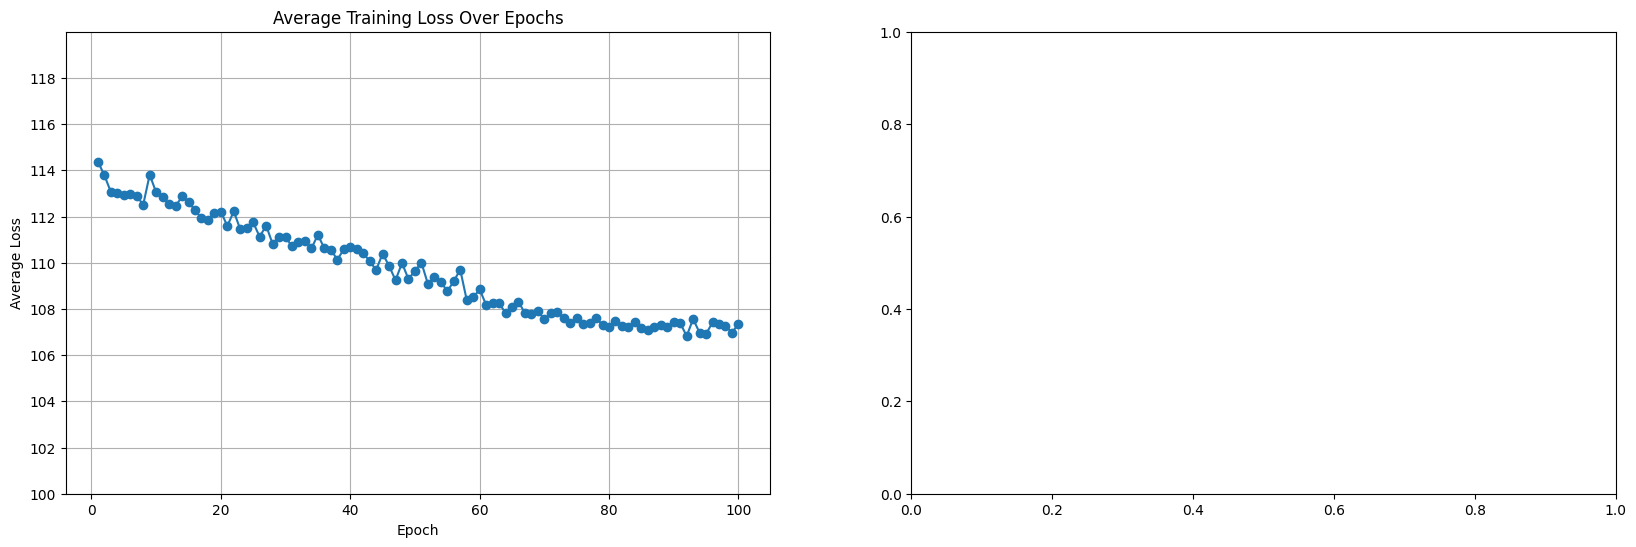

In [149]:
figure, axes = plt.subplots(figsize=(20, 6), ncols=2, nrows=1)
axes[0].plot(range(1, epochs + 1), average_losses, marker="o")
axes[0].set_title("Average Training Loss Over Epochs")
axes[0].set_xlabel("Epoch")

axes[0].set_ylabel("Average Loss")
axes[0].set_ylim(ymin=100, ymax=120)
axes[0].set_yticks(np.arange(100, 120, 2))
axes[0].grid()
# axes[1].plot(range(1, epochs + 1), c_indices, marker="o", color="orange")
# axes[1].set_title("C-index Over Epochs")
# axes[1].set_xlabel("Epoch")
# axes[1].set_ylabel("C-index")
# # axes[1].set_ylim(ymin=0)
# axes[1].set_yticks(np.arange(0, 1.01, 0.1))
# axes[1].grid()
plt.show()

In [150]:
test_loader = DataLoader(test_dataset, batch_size=2, shuffle=True)
for feature, label in test_loader:
    feature = feature.to(torch.float64).to(device)
    label = label.to(torch.float64).to(device)
    risks = model(feature, label[:, 0])
    if len(risks) == 2 and risks[0] == risks[1]:
        x_without_time = model.embed_without_time(feature)
        x_with_time = model.embed_with_time(feature, label[:, 0])
        per_patient_hazard = model.net_without_time(x_without_time)
        baseline_hazard = model.net_with_time(x_with_time)
        print("Per-patient hazard: ", per_patient_hazard)
        print("Baseline hazard: ", baseline_hazard)
        print("Found a pair with tied risk!")
        print("Real failure time: ", label[:, 0])
        print("Features: ", feature)
    break

/var/folders/mq/6cp6x0xn7t37vk02tn8lr6s40000gn/T/ipykernel_60242/3530787009.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(x[:, self.features.index(col)])
/var/folders/mq/6cp6x0xn7t37vk02tn8lr6s40000gn/T/ipykernel_60242/3530787009.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(x[:, self.features.index(col)])


In [151]:
from lib.metrics import dynamic_c_index

In [152]:
# After each epoch, evaluate C-index
model.eval()
with torch.no_grad():
    all_features = []
    all_times = []
    all_events = []

    for feature, label in test_loader:
        feature = feature.to(torch.float64).to(device)

        all_times.append(label[:, 0])  # Event times
        all_events.append(label[:, 1])  # Event indicators
        all_features.append(feature)

    all_features = torch.cat(all_features)
    all_times = torch.cat(all_times)
    all_events = torch.cat(all_events)
    c_idx = dynamic_c_index(model, all_features, all_times, all_events)
    print(f"C-index: {c_idx:.4f}")
print("Done!")

/var/folders/mq/6cp6x0xn7t37vk02tn8lr6s40000gn/T/ipykernel_60242/3530787009.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(x[:, self.features.index(col)])
/var/folders/mq/6cp6x0xn7t37vk02tn8lr6s40000gn/T/ipykernel_60242/3530787009.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(x[:, self.features.index(col)])


Concordant: 120389
Discordant: 64385
Tied Time: 728
C-index: 0.6515
Done!
